# 3.3 LangGraph에서 도구(tool) 활용 방법

- 도구(tool)를 활용한 에이전트 개발 방법을 알아봅니다
- workflow를 직접 선언하지 않고, 사용가능한 도구들을 전달하면, 에이전트가 적합한 도구를 판단해서 사용합니다
    - 이번 회차에서는 `ToolNode`를 통해 도구를 활용하는 방법을 알아봅니다

즉 다시 말해 LangGraph에서 도구 선언하는 방법을 알아본다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model = "gpt-4o" 
)

small_llm = ChatOpenAI(
    model = "gpt-4o-mini"
)

In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

LangGraph는 `ToolNode`를 통해 도구를 활용함  
`ToolNode`의 `invoke()`결과는 도구의 `invoke()` 결과와 유사함
- 도구는 도구의 실행 결과를 리턴하고, `ToolNode`는 도구의 실행 결과를 포함한 `ToolMessage`를 리턴   

LangGraph를 사용할 때는 도구를 LLM에 bind하고 그리고, ToolNode도 정의한다.

In [4]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

기존 Tool을 사용할 때는 인자를 입력했다.

In [5]:
multiply.invoke({'a': 3, 'b': 5})

15

In [6]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')

In [7]:
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jdt8LkYgg2fHJNReUT5YNoBV', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 84, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4526db9c-2b5f-4478-88f4-7fa06d67f5ca-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_Jdt8LkYgg2fHJNReUT5YNoBV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 17, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

(중요) `ToolNode`를 `invoke()`하려면 `tool_calls` 속성을 포함한 `AIMessage`를 전달해야 한다.

In [8]:
tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_Jdt8LkYgg2fHJNReUT5YNoBV')]}

- (중요) ToolNode는
    - 메시지 리스트만 받는다. The state MUST contain a list of messages.
    - 마지막 메시지가 AIMessage라야 한다. The last message MUST be an `AIMessage`.
    - The `AIMessage` MUST have `tool_calls` populated.

간단한 에이전트를 만들어 보자.  
이를 위해 LangGraph에서 제공하는 [`StateGraph`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)를 사용

Message 관련 State의 경우 LangGraph에서 내장으로 제공하는 것이 있다. (MessageState)

```python
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

앞에서는 그냥 만들어 썼다.

In [9]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

이제 노드를 만든다.   
첫번째로 agent

In [10]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    
    # LLM과 도구를 사용하여 메시지를 처리하고 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 새로운 상태로 반환합니다.
    return {'messages': [response]}

- 그냥 llm_with_tools를 invoke하여 응답을 생성하는 구성

마지막 메시지를 보고 도구를 사용했는지 참고해서 도구 사용여부 결정??

In [11]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메시지 상태를 기반으로 에이전트가 계속 진행할지 여부를 결정합니다.

    Args:
        state (MessagesState): `state`를 포함하는 객체.

    Returns:
        Literal['tools', END]: 도구를 사용해야 하면 `tools`를 리턴하고, 
        답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    
    # 마지막 AI 메시지를 가져옵니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'
    
    # 도구 호출이 없으면 END를 반환하여 프로세스를 종료합니다.
    return END

`node`를 추가하고 `edge`로 연결

In [12]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [13]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [14]:
graph= graph_builder.compile()

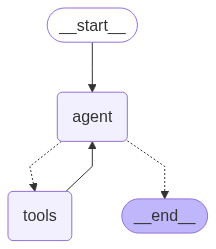

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

`graph.stream()`을 활용하면 에이전트가 답변을 생성하는 과정을 모니터링 할 수 있음

여기서는 인자가 messages(리스트)가 들어간다.

In [16]:
from langchain_core.messages import HumanMessage
# stream_model=values를 입력해야 full state 모두 볼수 있다.
for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_rM1sCNzqA657eEXl4EmZRhXA)
 Call ID: call_rM1sCNzqA657eEXl4EmZRhXA
  Args:
    a: 3
    b: 5
  multiply (call_D0ODKlVzONibxhBx9AbUj4fu)
 Call ID: call_D0ODKlVzONibxhBx9AbUj4fu
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: multiply

40
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ehdlokTgaDfhcPyJKt54rFxE)
 Call ID: call_ehdlokTgaDfhcPyJKt54rFxE
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================

3에 5를 더하면 8이고, 거기에 8을 곱하면 64입니다. 따라서 최종 결과는 64입니다.


- 처음 agent에 의해 add, multiply 도구를 써야겠다고 생각...   
- 그다음 덧셈 도구 사용  
- 그다음 곱셈 도구 사용  
- 마지막에 ToolMessage 없으므로 종료